Kernel: huggingface1

### Imports

In [1]:
import torch
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy

%matplotlib inline

/anaconda/envs/huggingface1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import io
import sys
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
# import supervision as sv

from IPython.core.display import display, HTML #DeprecationWarning    
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from PIL import Image

import matplotlib.pyplot as plt  

/tmp/ipykernel_16280/2315270169.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML #DeprecationWarning


In [3]:
# To import dataset, add relevant paths to system path

dataset_path = '../dataset'
util_path = '../util'

for path_to_add in [dataset_path, util_path]:

    # Select child directory
    child_dir = os.path.abspath(path_to_add)  
    # print(f'child_dir:{child_dir}')

    # Add the child directory to sys.path  
    if child_dir not in sys.path:  
        sys.path.append(child_dir)
        print(f'child_dir added to sys.path')
    else:
        print(f'child_dir already in sys.path')

child_dir added to sys.path
child_dir added to sys.path


In [4]:
from sklearn.model_selection import train_test_split  
from dataset import CaptionsDataset

### Config

In [5]:
# images_base_path = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/computeinstance10-gpu/code/datasets/face_mask/images'
# images_base_path = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/computeinstance10-1-gpu/code/datasets/face_mask/images'
images_base_path = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/computeinstance10-2-gpu/code/datasets/face_mask/images'

annotations_coco_path = '../annotations/face_bbox_annotations_sample.json' # File downloaded from AzureML as COCO file

annotations_captions_jsonl_base_path = '../annotations' # Train and test files will be created at this path
task = 'more_detailed_caption'

In [6]:
# model_id = 'microsoft/Florence-2-base'

# model_id = 'microsoft/Florence-2-large' # 

# model_id = 'microsoft/Florence-2-large-ft'

# model_id = 'microsoft/Florence-2-base-ft' # <-- Tested
model_id = 'microsoft/Florence-2-base' # <-- Testing
revision = None #'refs/pr/6'

print(f'model_id:{model_id}, revision:{revision}')

model_id:microsoft/Florence-2-base, revision:None


In [7]:
if model_id == 'microsoft/Florence-2-base-ft' or model_id == 'microsoft/Florence-2-base':
    test_size = 0.1
    BATCH_SIZE = 2
    NUM_WORKERS = 0
    EPOCHS = 11 #200 #400 #200 #100
    LR = 2e-6 #2e-6 #1e-6 #5e-6
elif model_id == 'microsoft/Florence-2-large':
    test_size = 0.1
    BATCH_SIZE = 1 # Samller batch size for bigger model
    NUM_WORKERS = 0
    EPOCHS = 10 #200 #400 #200 #100
    LR = 2e-6 #1e-6 #5e-6

In [8]:
device = 'cpu'

if torch.cuda.is_available():
    device='cuda'

print(f'device:{device}')

device:cuda


Annotations created by 'generate-annotations.ipynb' notebook

In [9]:
# use_trimmed_files = True

In [10]:
# if use_trimmed_files:
#     # Annotations created previously
#     annotations_jsonl_path_train = os.path.join(annotations_captions_jsonl_base_path, 'face_caption_annotations_sample' + '_train_trimmed' + '.jsonl')
#     annotations_jsonl_path_test = os.path.join(annotations_captions_jsonl_base_path, 'face_caption_annotations_sample' + '_test_trimmed' + '.jsonl')
# else:
#     # Annotations created previously
#     annotations_jsonl_path_train = os.path.join(annotations_captions_jsonl_base_path, 'face_caption_annotations_sample' + '_train' + '.jsonl')
#     annotations_jsonl_path_test = os.path.join(annotations_captions_jsonl_base_path, 'face_caption_annotations_sample' + '_test' + '.jsonl')
    
# print(f'annotations_jsonl_path_train:{annotations_jsonl_path_train}')
# print(f'annotations_jsonl_path_test:{annotations_jsonl_path_test}')

In [11]:
# Annotations created previously - text question/answer
annotations_jsonl_path_train = os.path.join(annotations_captions_jsonl_base_path, 'face_input_text_annotations_sample' + '_train' + '.jsonl')
annotations_jsonl_path_test = os.path.join(annotations_captions_jsonl_base_path, 'face_input_text_annotations_sample' + '_test' + '.jsonl')
    
print(f'annotations_jsonl_path_train:{annotations_jsonl_path_train}')
print(f'annotations_jsonl_path_test:{annotations_jsonl_path_test}')

annotations_jsonl_path_train:../annotations/face_input_text_annotations_sample_train.jsonl
annotations_jsonl_path_test:../annotations/face_input_text_annotations_sample_test.jsonl


### Common

In [12]:
def load_json(json_file_path):

    json_data = None

    with open(json_file_path, 'r') as file:
        json_data = json.load(file)

    return json_data 

In [13]:
def run_example(model, task_prompt, text_input=None):   
    
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    
    # MK
    # Move the Input Data to GPU
    if device == 'cuda':
        inputs = {k: v.to(device) for k, v in inputs.items()}  
         
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [14]:
def plot_loss(avg_train_loss_list, avg_val_loss_list, size=(10, 5), title='Training vs Validation Loss',   
              x_label='Epochs', y_label='Loss', train_legend='Training Loss', val_legend='Validation Loss'):  
    
    # Set the size of the plot  
    plt.figure(figsize=size)  
      
    # Plot training and validation loss  
    plt.plot(avg_train_loss_list, label=train_legend)  
    plt.plot(avg_val_loss_list, label=val_legend)  
      
    # Adding title and labels  
    plt.title(title)  
    plt.xlabel(x_label)  
    plt.ylabel(y_label)  
      
    # Show legend  
    plt.legend()  
      
    # Show the plot  
    plt.show()

### Model

In [15]:
model = None
processor = None

if revision:
    # model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).eval().to(device)
    model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, revision = revision).to(device)
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True, revision = revision)
else: # Ignore revision
    model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).to(device)
    processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)  

print(f'Model loaded')

Model loaded


### Dataset

In [16]:
# Initiate Dataset and DataLoader for train and validation subsets

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    # print(f'questions: {questions}, answers: {answers}, images:{images}')
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

train_dataset = CaptionsDataset(
    jsonl_file_path = annotations_jsonl_path_train,
    image_directory_path = images_base_path
)

val_dataset = CaptionsDataset(
    jsonl_file_path = annotations_jsonl_path_test,
    image_directory_path = images_base_path
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [17]:
torch.cuda.empty_cache()

### Fine-tune

In [18]:
# training loop
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    avg_train_loss_list = []
    avg_val_loss_list = []
    
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            
            # print(f'answers:{answers}')

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")
        avg_train_loss_list.append(avg_train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")
            avg_val_loss_list.append(avg_val_loss)


    # MK
    # Save last epoch
    checkpoint_path = '../model_checkpoints/' + model_id.replace('/','_').replace('-','_').replace(' ','_') + '_' + task + '_full_epoch_' + str(EPOCHS)
    output_dir = checkpoint_path
    os.makedirs(output_dir, exist_ok=True)
    model.save_pretrained(output_dir)
    processor.save_pretrained(output_dir)
    
    return avg_train_loss_list, avg_val_loss_list

In [19]:
# # Freeze vision encoder
# for param in model.vision_tower.parameters():
#     param.is_trainable = False

/anaconda/envs/huggingface1/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Training Epoch 1/11: 100%|██████████| 896/896 [08:44<00:00,  1.71it/s]


Average Training Loss: 1.0017748677990832


Validation Epoch 1/11: 100%|██████████| 100/100 [00:23<00:00,  4.25it/s]


Average Validation Loss: 0.34411070592701437


Training Epoch 2/11: 100%|██████████| 896/896 [08:44<00:00,  1.71it/s]


Average Training Loss: 0.3490503293453782


Validation Epoch 2/11: 100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


Average Validation Loss: 0.2752732475288212


Training Epoch 3/11: 100%|██████████| 896/896 [08:36<00:00,  1.73it/s]


Average Training Loss: 0.2626550050964787


Validation Epoch 3/11: 100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


Average Validation Loss: 0.2595488592516631


Training Epoch 4/11: 100%|██████████| 896/896 [08:36<00:00,  1.73it/s]


Average Training Loss: 0.20988279684310587


Validation Epoch 4/11: 100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


Average Validation Loss: 0.2355621007923037


Training Epoch 5/11: 100%|██████████| 896/896 [08:38<00:00,  1.73it/s]


Average Training Loss: 0.16849952362073445


Validation Epoch 5/11: 100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


Average Validation Loss: 0.23452942756004633


Training Epoch 6/11: 100%|██████████| 896/896 [08:33<00:00,  1.75it/s]


Average Training Loss: 0.14348808650902356


Validation Epoch 6/11: 100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


Average Validation Loss: 0.2321076655574143


Training Epoch 7/11: 100%|██████████| 896/896 [08:40<00:00,  1.72it/s]


Average Training Loss: 0.12270670614140856


Validation Epoch 7/11: 100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


Average Validation Loss: 0.23680496886372565


Training Epoch 8/11: 100%|██████████| 896/896 [08:36<00:00,  1.73it/s]


Average Training Loss: 0.10650701416508516


Validation Epoch 8/11: 100%|██████████| 100/100 [00:23<00:00,  4.31it/s]


Average Validation Loss: 0.23884916624287145


Training Epoch 9/11: 100%|██████████| 896/896 [08:40<00:00,  1.72it/s]


Average Training Loss: 0.09296084319456506


Validation Epoch 9/11: 100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


Average Validation Loss: 0.23506870664830784


Training Epoch 10/11: 100%|██████████| 896/896 [08:40<00:00,  1.72it/s]


Average Training Loss: 0.08332455895151725


Validation Epoch 10/11: 100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Average Validation Loss: 0.23977898643817752


Training Epoch 11/11: 100%|██████████| 896/896 [08:37<00:00,  1.73it/s]


Average Training Loss: 0.07751594295586983


Validation Epoch 11/11: 100%|██████████| 100/100 [00:22<00:00,  4.43it/s]


Average Validation Loss: 0.23870337548316456


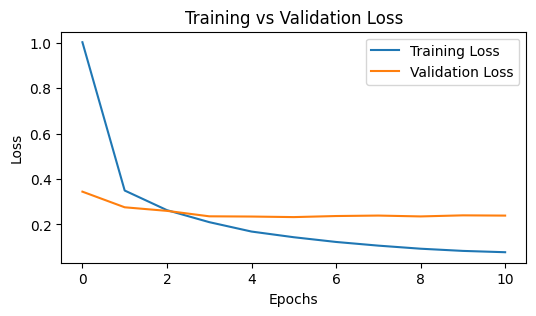

CPU times: user 1h 14min 40s, sys: 16min 17s, total: 1h 30min 57s
Wall time: 1h 39min 32s


In [20]:
%%time
avg_train_loss_list, avg_val_loss_list = train_model(train_loader, val_loader, model, processor, epochs=EPOCHS, lr=LR)

plot_loss(avg_train_loss_list, avg_val_loss_list, size=(6, 3), title='Training vs Validation Loss',   
              x_label='Epochs', y_label='Loss', train_legend='Training Loss', val_legend='Validation Loss')

### Load fine-tuned model

AssertionError: only DaViT is supported for now.

https://medium.com/@tahamansoor.liqteq/fine-tuning-florence-2-base-model-on-a-custom-dataset-for-image-captioning-a7861b15fbf8

In [22]:
checkpoint_path = '../model_checkpoints/' + model_id.replace('/','_').replace('-','_').replace(' ','_') + '_' + task + '_full_epoch_' + str(EPOCHS)

model_ft = AutoModelForCausalLM.from_pretrained(checkpoint_path, trust_remote_code=True, revision = revision).to(device)
processor = AutoProcessor.from_pretrained(checkpoint_path, trust_remote_code=True, revision = revision)

print(f'Loaded checkpoint_path:{checkpoint_path}')

Loaded checkpoint_path:../model_checkpoints/microsoft_Florence_2_base_more_detailed_caption_full_epoch_11


use_own_image: True


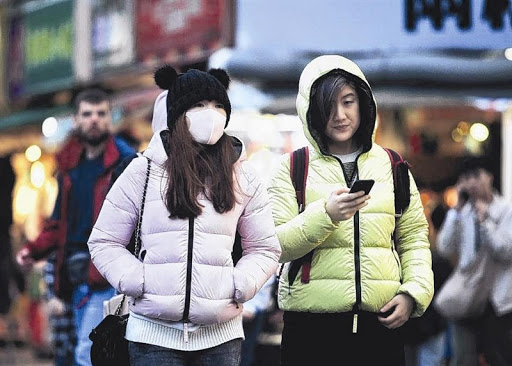

In [43]:
use_own_image = True
image_path = os.path.join(images_base_path,'maksssksksss0.png')
# image_path = os.path.join(images_base_path,'maksssksksss605.png')
# image_path = os.path.join(images_base_path,'maksssksksss711.png')
# image_path = os.path.join(images_base_path,'maksssksksss720.png')
# image_path = os.path.join(images_base_path,'maksssksksss750.png')
# image_path = os.path.join(images_base_path,'maksssksksss790.png')

print(f'use_own_image: {use_own_image}')

if not use_own_image:
    url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
    image = Image.open(requests.get(url, stream=True).raw)
else:    
    image = Image.open(image_path).convert('RGB')
    
# See input image
image

In [46]:
%%time

print(f'use_own_image:{use_own_image}')
# task_prompt = '<MORE_DETAILED_CAPTION>'

# "question_1": "What are people doing?",
# "answer_1": "Walking, people are walking on a street.",

# "question_2": "Does this look like a photo taken indoors?",
# "answer_2": "No, it looks like it was taken outdoors.",

# "question_3": "Is this photo taken during the day or night?",
# "answer_3": "Evening, it appears to be taken during the evening (or night) due to the lighting.",

# "question_4": "Are people carrying any items?",
# "answer_4": "Yes, one person is holding a mobile phone."

q_list = ['What are people doing?',
          'Does this look like a photo taken indoors?',
          'Is this photo taken during the day or night?',
          'Are people carrying any items?']

for task_prompt in q_list:    

    results = run_example(model_ft,task_prompt)
    print(results)

use_own_image:True
{'What are people doing?': 'Walking, people are walking on a busy street.'}
{'Does this look like a photo taken indoors?': 'No, it looks like it was taken outdoors.'}
{'Is this photo taken during the day or night?': 'Day, it appears to be taken during the day due to the natural lighting.'}
{'Are people carrying any items?': 'Yes, one person is holding a mobile phone and the other has a backpack.'}
CPU times: user 963 ms, sys: 0 ns, total: 963 ms
Wall time: 923 ms
